# NILM Pretraining - Configurable Resolution
---

This notebook prepares model-ready numpy arrays from the preprocessed **1-second data**, with **configurable resampling** for optimal Transformer context.

## ⚙️ Quick Configuration
Change `RESAMPLE_SEC` in the configuration cell to adjust resolution:

| RESAMPLE_SEC | Window 720 = | Context | Use Case |
|--------------|--------------|---------|----------|
| 1 | 12 min | Short | Transient detection |
| 5 | **1 hour** | **Recommended** | Full appliance cycles |
| 10 | 2 hours | Long | Daily patterns |
| 30 | 6 hours | Very long | Multi-cycle patterns |

## Why Variable Resolution?
- **1 sec**: Max detail, but short context (512 samples = 8.5 min)
- **5 sec**: Good balance - 720 samples = 1 hour context ✅
- **10 sec**: UK-DALE style - 720 samples = 2 hours
- **15 min**: Already available in separate pipeline

## Data Characteristics
- **Source**: 1sec_new data (native 1-second)
- **Resampling**: Configurable via `RESAMPLE_SEC`
- **Usable Periods**:
  - Period B: 2024-07-01 → 2024-09-30 (92 days)
  - Period C: 2024-10-09 → 2025-09-30 (356 days)

## Pipeline:
1. Load preprocessed Parquet (1-second native)
2. **Resample to configured resolution** (if > 1 sec)
3. Block-interleaved splits (seasonal coverage)
4. Create windowed sequences
5. Export numpy arrays

## 0. Setup

In [25]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# ⚙️ MAIN CONFIGURATION - CHANGE THIS TO ADJUST RESOLUTION
# =============================================================================
RESAMPLE_SEC = 5  # Target resolution in seconds (1=no resample, 5, 10, 30, etc.)

# Window and stride configuration
WINDOW_SIZE = 1024       # Number of samples per window
STRIDE = 256           # Samples between consecutive windows

# =============================================================================
# Derived values
# =============================================================================
WINDOW_MINUTES = WINDOW_SIZE * RESAMPLE_SEC / 60
WINDOW_HOURS = WINDOW_SIZE * RESAMPLE_SEC / 3600
STRIDE_MINUTES = STRIDE * RESAMPLE_SEC / 60

print("="*70)
print("⚙️ CONFIGURATION")
print("="*70)
print(f"  Target resolution: {RESAMPLE_SEC} seconds")
print(f"  Window: {WINDOW_SIZE} samples = {WINDOW_MINUTES:.0f} min = {WINDOW_HOURS:.1f} hours")
print(f"  Stride: {STRIDE} samples = {STRIDE_MINUTES:.0f} minutes")
print("="*70)

# Paths
BASE_DIR = Path('.').resolve().parent
DATA_DIR = BASE_DIR / 'data' / 'processed' / '1sec_new'
OUTPUT_DIR = DATA_DIR / 'model_ready'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"\nBase directory: {BASE_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

⚙️ CONFIGURATION
  Target resolution: 5 seconds
  Window: 1024 samples = 85 min = 1.4 hours
  Stride: 256 samples = 21 minutes

Base directory: C:\Users\gamek\School\TeamProject\MTS3-MCTE-Team-Project-Energy-G1
Data directory: C:\Users\gamek\School\TeamProject\MTS3-MCTE-Team-Project-Energy-G1\data\processed\1sec_new
Output directory: C:\Users\gamek\School\TeamProject\MTS3-MCTE-Team-Project-Energy-G1\data\processed\1sec_new\model_ready


In [26]:
# Load dataset and resample using Pandas in chunks (memory-efficient)
import pyarrow.parquet as pq
from tqdm import tqdm

input_file = DATA_DIR / 'nilm_ready_1sec_new.parquet'
    
if not input_file.exists():
    raise FileNotFoundError(
        f"Dataset not found at {input_file}\n"
        "Please run 'data_preparation_1sec_new.ipynb' first!"
    )

print("="*70)
print(f"📂 LOADING & RESAMPLING TO {RESAMPLE_SEC}-SECOND RESOLUTION")
print("="*70)

# Get file info
parquet_file = pq.ParquetFile(input_file)
original_rows = parquet_file.metadata.num_rows
print(f"Original: {original_rows:,} rows @ 1 second")

# Process in smaller chunks
CHUNK_SIZE = 2_000_000  # 2M rows per chunk
n_chunks = (original_rows // CHUNK_SIZE) + 1
print(f"Processing in {n_chunks} chunks of {CHUNK_SIZE:,} rows each...")

chunks_resampled = []
for batch in tqdm(parquet_file.iter_batches(batch_size=CHUNK_SIZE), total=n_chunks, desc="Resampling"):
    chunk_df = batch.to_pandas()
    chunk_df['Time'] = pd.to_datetime(chunk_df['Time'])
    
    if RESAMPLE_SEC > 1:
        # Resample this chunk - efficient method
        chunk_df = chunk_df.set_index('Time').resample(f'{RESAMPLE_SEC}s').mean()
        chunk_df = chunk_df.reset_index()
    
    chunks_resampled.append(chunk_df)

# Concatenate
print("\nConcatenating chunks...")
df = pd.concat(chunks_resampled, ignore_index=True)
del chunks_resampled  # Free memory

# Sort and remove duplicates at chunk boundaries
df = df.sort_values('Time').drop_duplicates(subset=['Time']).reset_index(drop=True)

# Drop NaN once at the end
rows_before = len(df)
df = df.dropna()
if rows_before - len(df) > 0:
    print(f"Dropped {rows_before - len(df):,} NaN rows")

print(f"\n✅ Final dataset:")
print(f"   Original: {original_rows:,} rows @ 1 second")
print(f"   After resample: {len(df):,} rows @ {RESAMPLE_SEC} seconds")
print(f"   Reduction factor: {original_rows / len(df):.1f}x")
print(f"   Memory: {df.memory_usage(deep=True).sum() / 1e9:.2f} GB")
print(f"   Time range: {df['Time'].min()} → {df['Time'].max()}")
print(f"   Columns: {list(df.columns)}")

📂 LOADING & RESAMPLING TO 5-SECOND RESOLUTION
Original: 37,364,405 rows @ 1 second
Processing in 19 chunks of 2,000,000 rows each...


Resampling: 100%|██████████| 19/19 [00:08<00:00,  2.15it/s]



Concatenating chunks...
Dropped 422,021 NaN rows

✅ Final dataset:
   Original: 37,364,405 rows @ 1 second
   After resample: 7,474,939 rows @ 5 seconds
   Reduction factor: 5.0x
   Memory: 1.20 GB
   Time range: 2024-07-01 00:00:00+00:00 → 2025-09-30 23:59:55+00:00
   Columns: ['Time', 'Aggregate', 'HeatPump', 'Dishwasher', 'WashingMachine', 'Dryer', 'Oven', 'Stove', 'RangeHood', 'EVCharger', 'EVSocket', 'GarageCabinet', 'RainwaterPump', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos']


## 1. Configuration

In [27]:
# ============================================================
# DERIVED CONFIGURATION (uses RESAMPLE_SEC from above)
# ============================================================

# Resolution (after resampling)
RESOLUTION_SEC = RESAMPLE_SEC
SAMPLES_PER_HOUR = 3600 // RESOLUTION_SEC
SAMPLES_PER_DAY = 24 * SAMPLES_PER_HOUR

# Block interleaved split (seasonal coverage)
BLOCK_DAYS = 7
PATTERN = [0, 0, 0, 0, 1, 2]  # 0=Train, 1=Val, 2=Test
BLOCK_SIZE = BLOCK_DAYS * SAMPLES_PER_DAY

# All available appliances
APPLIANCE_COLUMNS = [
    'HeatPump', 'Dishwasher', 'WashingMachine', 'Dryer',
    'Oven', 'Stove', 'RangeHood', 'EVCharger', 'EVSocket',
    'GarageCabinet', 'RainwaterPump'
]

# Temporal features (cyclical encoding)
TEMPORAL_FEATURES = ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos']

# Input features: Aggregate + Temporal
INPUT_FEATURES = ['Aggregate'] + TEMPORAL_FEATURES

# Summary
print("="*70)
print("📊 FINAL CONFIGURATION SUMMARY")
print("="*70)
print(f"  Resolution: {RESOLUTION_SEC} sec {'(resampled)' if RESOLUTION_SEC > 1 else '(native)'}")
print(f"  Samples/hour: {SAMPLES_PER_HOUR:,}")
print(f"  Samples/day: {SAMPLES_PER_DAY:,}")
print(f"  Window: {WINDOW_SIZE} samples = {WINDOW_SIZE * RESOLUTION_SEC / 60:.0f} min = {WINDOW_SIZE * RESOLUTION_SEC / 3600:.1f} hours")
print(f"  Stride: {STRIDE} samples = {STRIDE * RESOLUTION_SEC / 60:.0f} min between windows")
print(f"  Input features: {len(INPUT_FEATURES)}")
print(f"  Target appliances: {len(APPLIANCE_COLUMNS)}")
print("="*70)

📊 FINAL CONFIGURATION SUMMARY
  Resolution: 5 sec (resampled)
  Samples/hour: 720
  Samples/day: 17,280
  Window: 1024 samples = 85 min = 1.4 hours
  Stride: 256 samples = 21 min between windows
  Input features: 7
  Target appliances: 11


## 2. Block Interleaved Train/Val/Test Split (Seasonal)

In [28]:
# Filter to existing appliance columns
existing_appliances = [c for c in APPLIANCE_COLUMNS if c in df.columns]
print(f"Existing appliances ({len(existing_appliances)}): {existing_appliances}")

# Check for any missing
missing = set(APPLIANCE_COLUMNS) - set(existing_appliances)
if missing:
    print(f"⚠️ Missing appliances (will be excluded): {missing}")
    APPLIANCE_COLUMNS = existing_appliances

Existing appliances (11): ['HeatPump', 'Dishwasher', 'WashingMachine', 'Dryer', 'Oven', 'Stove', 'RangeHood', 'EVCharger', 'EVSocket', 'GarageCabinet', 'RainwaterPump']


In [ ]:
# Block time-series split (interleaved, seasonal)

def block_time_series_split(
    df: pd.DataFrame,
    block_days: int = 7,
    pattern: list = None,
    time_column: str = 'Time',
    resolution_sec: int = 5
) -> tuple:
    """
    Split time-series data into Train/Val/Test using interleaved blocks.
    """
    if pattern is None:
        pattern = [0, 0, 0, 0, 1, 2]
    df = df.copy()
    df[time_column] = pd.to_datetime(df[time_column])
    df = df.sort_values(time_column).reset_index(drop=True)
    samples_per_day = 24 * 3600 // resolution_sec
    block_size = block_days * samples_per_day
    df['_block'] = df.index // block_size
    df['_set'] = df['_block'].apply(lambda x: pattern[x % len(pattern)])
    train_df = df[df['_set'] == 0].drop(columns=['_block', '_set'])
    val_df = df[df['_set'] == 1].drop(columns=['_block', '_set'])
    test_df = df[df['_set'] == 2].drop(columns=['_block', '_set'])
    return train_df, val_df, test_df

# Apply block split
train_df, val_df, test_df = block_time_series_split(
    df,
    block_days=BLOCK_DAYS,
    pattern=PATTERN,
    resolution_sec=RESOLUTION_SEC
)

# Summary
total = len(train_df) + len(val_df) + len(test_df)
print(f"{'Set':<12} {'Rows':>12} {'%':>8}")
print("-" * 40)
print(f"{'Train':<12} {len(train_df):>12,} {100*len(train_df)/total:>7.1f}%")
print(f"{'Validation':<12} {len(val_df):>12,} {100*len(val_df)/total:>7.1f}%")
print(f"{'Test':<12} {len(test_df):>12,} {100*len(test_df)/total:>7.1f}%")
print("-" * 40)
print(f"{'Total':<12} {total:>12,}")

## 3. Scaling

In [ ]:
# =============================================================================
# NILM-CORRECT SCALING STRATEGY
# =============================================================================
# 
# ✅ Power signals (Aggregate + Appliances): SINGLE scaler based on max(Aggregate)
# ✅ Temporal features (sin/cos): NO SCALING - already in [-1, 1]
# ❌ StandardScaler: NEVER for power (creates artificial negatives)
# ❌ Separate scalers per appliance: BREAKS energy conservation
#
# This preserves physical meaning and enables energy consistency loss

# Identify column types
POWER_COLUMNS = ['Aggregate'] + APPLIANCE_COLUMNS
TEMPORAL_COLUMNS = TEMPORAL_FEATURES  # sin/cos already in [-1, 1]

# Verify columns exist
power_cols_exist = [c for c in POWER_COLUMNS if c in df.columns]
temporal_cols_exist = [c for c in TEMPORAL_COLUMNS if c in df.columns]

print("="*70)
print("⚡ NILM-CORRECT SCALING STRATEGY")
print("="*70)
print(f"\n📊 Power columns ({len(power_cols_exist)}):")
print(f"   → Will be scaled by max(Aggregate) from TRAIN only")
for c in power_cols_exist:
    print(f"      • {c}")

print(f"\n🕐 Temporal columns ({len(temporal_cols_exist)}):")
print(f"   → NO SCALING (already in [-1, 1])")
for c in temporal_cols_exist:
    print(f"      • {c}")

# Update global
POWER_COLUMNS = power_cols_exist

⚡ NILM-CORRECT SCALING STRATEGY

📊 Power columns (12):
   → Will be scaled by max(Aggregate) from TRAIN only
      • Aggregate
      • HeatPump
      • Dishwasher
      • WashingMachine
      • Dryer
      • Oven
      • Stove
      • RangeHood
      • EVCharger
      • EVSocket
      • GarageCabinet
      • RainwaterPump

🕐 Temporal columns (6):
   → NO SCALING (already in [-1, 1])
      • hour_sin
      • hour_cos
      • dow_sin
      • dow_cos
      • month_sin
      • month_cos


In [ ]:
# =============================================================================
# NILM-CORRECT SCALING: Single P_MAX from Aggregate (TRAIN only)
# =============================================================================

# Step 1: Calculate P_MAX from TRAIN Aggregate only (no data leakage)
P_MAX = train_df['Aggregate'].max()

print("="*70)
print("⚡ SCALING POWER SIGNALS")
print("="*70)
print(f"P_MAX (from train Aggregate): {P_MAX:.2f} W")
print(f"This single value scales ALL power columns (energy conservation)")

# Step 2: Scale power columns (same scale for Aggregate AND all appliances)
train_power_scaled = train_df[POWER_COLUMNS].values / P_MAX
val_power_scaled = val_df[POWER_COLUMNS].values / P_MAX
test_power_scaled = test_df[POWER_COLUMNS].values / P_MAX

# Step 3: Temporal features - NO SCALING (already [-1, 1])
train_temporal = train_df[temporal_cols_exist].values
val_temporal = val_df[temporal_cols_exist].values
test_temporal = test_df[temporal_cols_exist].values

# Step 4: Combine into final arrays
# Order: Power columns first, then temporal
all_feature_columns = POWER_COLUMNS + temporal_cols_exist

train_scaled = np.hstack([train_power_scaled, train_temporal])
val_scaled = np.hstack([val_power_scaled, val_temporal])
test_scaled = np.hstack([test_power_scaled, test_temporal])

print(f"\n📊 Scaled arrays:")
print(f"  Train: {train_scaled.shape}")
print(f"  Val:   {val_scaled.shape}")
print(f"  Test:  {test_scaled.shape}")

print(f"\n📈 Value ranges after scaling:")
print(f"  Power columns (scaled by P_MAX):")
print(f"    Train: [{train_power_scaled.min():.4f}, {train_power_scaled.max():.4f}]")
print(f"    Val:   [{val_power_scaled.min():.4f}, {val_power_scaled.max():.4f}]")
print(f"    Test:  [{test_power_scaled.min():.4f}, {test_power_scaled.max():.4f}]")
print(f"  Temporal columns (untouched, sin/cos):")
print(f"    Range: [{train_temporal.min():.4f}, {train_temporal.max():.4f}]")

# Verify energy conservation principle
agg_idx = POWER_COLUMNS.index('Aggregate')
appliance_indices = [i for i, c in enumerate(POWER_COLUMNS) if c != 'Aggregate']
train_agg_sum = train_power_scaled[:, agg_idx].mean()
train_app_sum = train_power_scaled[:, appliance_indices].sum(axis=1).mean()
print(f"\n✅ Energy check (train means):")
print(f"   Aggregate mean: {train_agg_sum:.4f}")
print(f"   Sum appliances mean: {train_app_sum:.4f}")
print(f"   Ratio (should be ~1 if all loads measured): {train_app_sum/train_agg_sum:.2f}")

⚡ SCALING POWER SIGNALS
P_MAX (from train Aggregate): 13.51 W
This single value scales ALL power columns (energy conservation)

📊 Scaled arrays:
  Train: (5055739, 18)
  Val:   (1209600, 18)
  Test:  (1209600, 18)

📈 Value ranges after scaling:
  Power columns (scaled by P_MAX):
    Train: [0.0000, 1.0000]
    Val:   [0.0000, 0.8316]
    Test:  [0.0000, 0.8929]
  Temporal columns (untouched, sin/cos):
    Range: [-1.0000, 1.0000]

✅ Energy check (train means):
   Aggregate mean: 0.0555
   Sum appliances mean: 0.0377
   Ratio (should be ~1 if all loads measured): 0.68


In [ ]:
# =============================================================================
# SAVE SCALING PARAMETERS (for inference)
# =============================================================================

# Save P_MAX (the ONLY scaling parameter needed for NILM)
scaling_params = {
    'P_MAX': float(P_MAX),
    'power_columns': POWER_COLUMNS,
    'temporal_columns': temporal_cols_exist,
    'all_feature_columns': all_feature_columns,
    'scaling_method': 'power / P_MAX (NILM-correct)',
    'notes': [
        'P_MAX = max(Aggregate) from TRAIN only',
        'All power columns use SAME P_MAX (energy conservation)',
        'Temporal sin/cos features are NOT scaled',
        'For inference: power_W = pred_scaled * P_MAX'
    ]
}

# Save as pickle
scaler_path = OUTPUT_DIR / 'scaling_params.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaling_params, f)

# Also save P_MAX separately for easy access
pmax_path = OUTPUT_DIR / 'P_MAX.pkl'
with open(pmax_path, 'wb') as f:
    pickle.dump(P_MAX, f)

print("="*70)
print("💾 SAVED SCALING PARAMETERS")
print("="*70)
print(f"  scaling_params.pkl: {scaler_path}")
print(f"  P_MAX.pkl: {pmax_path}")
print(f"\n  P_MAX = {P_MAX:.2f} W")

print(f"\n📋 Feature column order ({len(all_feature_columns)}):")
for idx, name in enumerate(all_feature_columns):
    scaling_type = "power/P_MAX" if name in POWER_COLUMNS else "none (sin/cos)"
    print(f"  [{idx:2d}] {name:<20} → {scaling_type}")

print(f"\n🔄 For inference de-scaling:")
print(f"   power_watts = prediction * {P_MAX:.2f}")

💾 SAVED SCALING PARAMETERS
  scaling_params.pkl: C:\Users\gamek\School\TeamProject\MTS3-MCTE-Team-Project-Energy-G1\data\processed\1sec_new\model_ready\scaling_params.pkl
  P_MAX.pkl: C:\Users\gamek\School\TeamProject\MTS3-MCTE-Team-Project-Energy-G1\data\processed\1sec_new\model_ready\P_MAX.pkl

  P_MAX = 13.51 W

📋 Feature column order (18):
  [ 0] Aggregate            → power/P_MAX
  [ 1] HeatPump             → power/P_MAX
  [ 2] Dishwasher           → power/P_MAX
  [ 3] WashingMachine       → power/P_MAX
  [ 4] Dryer                → power/P_MAX
  [ 5] Oven                 → power/P_MAX
  [ 6] Stove                → power/P_MAX
  [ 7] RangeHood            → power/P_MAX
  [ 8] EVCharger            → power/P_MAX
  [ 9] EVSocket             → power/P_MAX
  [10] GarageCabinet        → power/P_MAX
  [11] RainwaterPump        → power/P_MAX
  [12] hour_sin             → none (sin/cos)
  [13] hour_cos             → none (sin/cos)
  [14] dow_sin              → none (sin/cos)
  [15] dow_cos 

## 4. Windowing (Sequence Generation)

In [ ]:
def create_sequences(
    data: np.ndarray,
    window_size: int,
    input_indices: list,
    target_indices: list,
    stride: int = 1
) -> tuple:
    """
    Create sliding window sequences for Transformer.
    
    Parameters
    ----------
    data : np.ndarray
        Scaled data array (samples, features)
    window_size : int
        Number of time steps per sequence
    input_indices : list
        Column indices for input features
    target_indices : list
        Column indices for target appliances
    stride : int
        Step size between windows
    
    Returns
    -------
    tuple: (X, y) arrays
        X shape: (n_samples, window_size, n_input_features)
        y shape: (n_samples, window_size, n_appliances)
    """
    n_samples = (len(data) - window_size) // stride + 1
    
    X = np.zeros((n_samples, window_size, len(input_indices)), dtype=np.float32)
    y = np.zeros((n_samples, window_size, len(target_indices)), dtype=np.float32)
    
    for i in range(n_samples):
        start = i * stride
        end = start + window_size
        X[i] = data[start:end, input_indices]
        y[i] = data[start:end, target_indices]
    
    return X, y

In [ ]:
# =============================================================================
# COLUMN INDICES (updated for NILM-correct feature order)
# =============================================================================
# Order: [Aggregate, Appliances..., Temporal...]

# Input: Aggregate + Temporal features
input_feature_names = ['Aggregate'] + temporal_cols_exist
input_indices = [all_feature_columns.index(f) for f in input_feature_names]

# Target: All appliances (NOT Aggregate)
target_appliance_names = [c for c in POWER_COLUMNS if c != 'Aggregate']
target_indices = [all_feature_columns.index(f) for f in target_appliance_names]

print("="*70)
print("📊 FEATURE INDICES FOR SEQUENCE CREATION")
print("="*70)

print(f"\n🔹 INPUT features ({len(input_indices)}):")
for i in input_indices:
    print(f"   [{i:2d}] {all_feature_columns[i]}")

print(f"\n🔸 TARGET appliances ({len(target_indices)}):")
for i in target_indices:
    print(f"   [{i:2d}] {all_feature_columns[i]}")

print(f"\n✅ Total features: {len(all_feature_columns)}")
print(f"   Power (scaled): {len(POWER_COLUMNS)}")
print(f"   Temporal (raw): {len(temporal_cols_exist)}")

📊 FEATURE INDICES FOR SEQUENCE CREATION

🔹 INPUT features (7):
   [ 0] Aggregate
   [12] hour_sin
   [13] hour_cos
   [14] dow_sin
   [15] dow_cos
   [16] month_sin
   [17] month_cos

🔸 TARGET appliances (11):
   [ 1] HeatPump
   [ 2] Dishwasher
   [ 3] WashingMachine
   [ 4] Dryer
   [ 5] Oven
   [ 6] Stove
   [ 7] RangeHood
   [ 8] EVCharger
   [ 9] EVSocket
   [10] GarageCabinet
   [11] RainwaterPump

✅ Total features: 18
   Power (scaled): 12
   Temporal (raw): 6


In [ ]:
# Using STRIDE from configuration (144 = every 12 minutes)

print(f"Creating sequences...")
print(f"  Window: {WINDOW_SIZE} samples = {WINDOW_SIZE * RESOLUTION_SEC / 60:.0f} minutes = {WINDOW_SIZE * RESOLUTION_SEC / 3600:.1f} hours")
print(f"  Stride: {STRIDE} samples = {STRIDE * RESOLUTION_SEC / 60:.0f} minutes between windows")

# Create sequences
X_train, y_train = create_sequences(train_scaled, WINDOW_SIZE, input_indices, target_indices, stride=STRIDE)
X_val, y_val = create_sequences(val_scaled, WINDOW_SIZE, input_indices, target_indices, stride=STRIDE)
X_test, y_test = create_sequences(test_scaled, WINDOW_SIZE, input_indices, target_indices, stride=STRIDE)

print(f"\nSequence shapes:")
print(f"  X_train: {X_train.shape} (samples, window, features)")
print(f"  y_train: {y_train.shape} (samples, window, appliances)")
print(f"  X_val:   {X_val.shape}")
print(f"  y_val:   {y_val.shape}")
print(f"  X_test:  {X_test.shape}")
print(f"  y_test:  {y_test.shape}")

# Memory estimate
total_bytes = (X_train.nbytes + y_train.nbytes + X_val.nbytes + y_val.nbytes + X_test.nbytes + y_test.nbytes)
print(f"\nTotal memory: {total_bytes / 1e9:.2f} GB")

Creating sequences...
  Window: 1024 samples = 85 minutes = 1.4 hours
  Stride: 256 samples = 21 minutes between windows

Sequence shapes:
  X_train: (19745, 1024, 7) (samples, window, features)
  y_train: (19745, 1024, 11) (samples, window, appliances)
  X_val:   (4722, 1024, 7)
  y_val:   (4722, 1024, 11)
  X_test:  (4722, 1024, 7)
  y_test:  (4722, 1024, 11)

Total memory: 2.15 GB


## 5. Verify Sequences

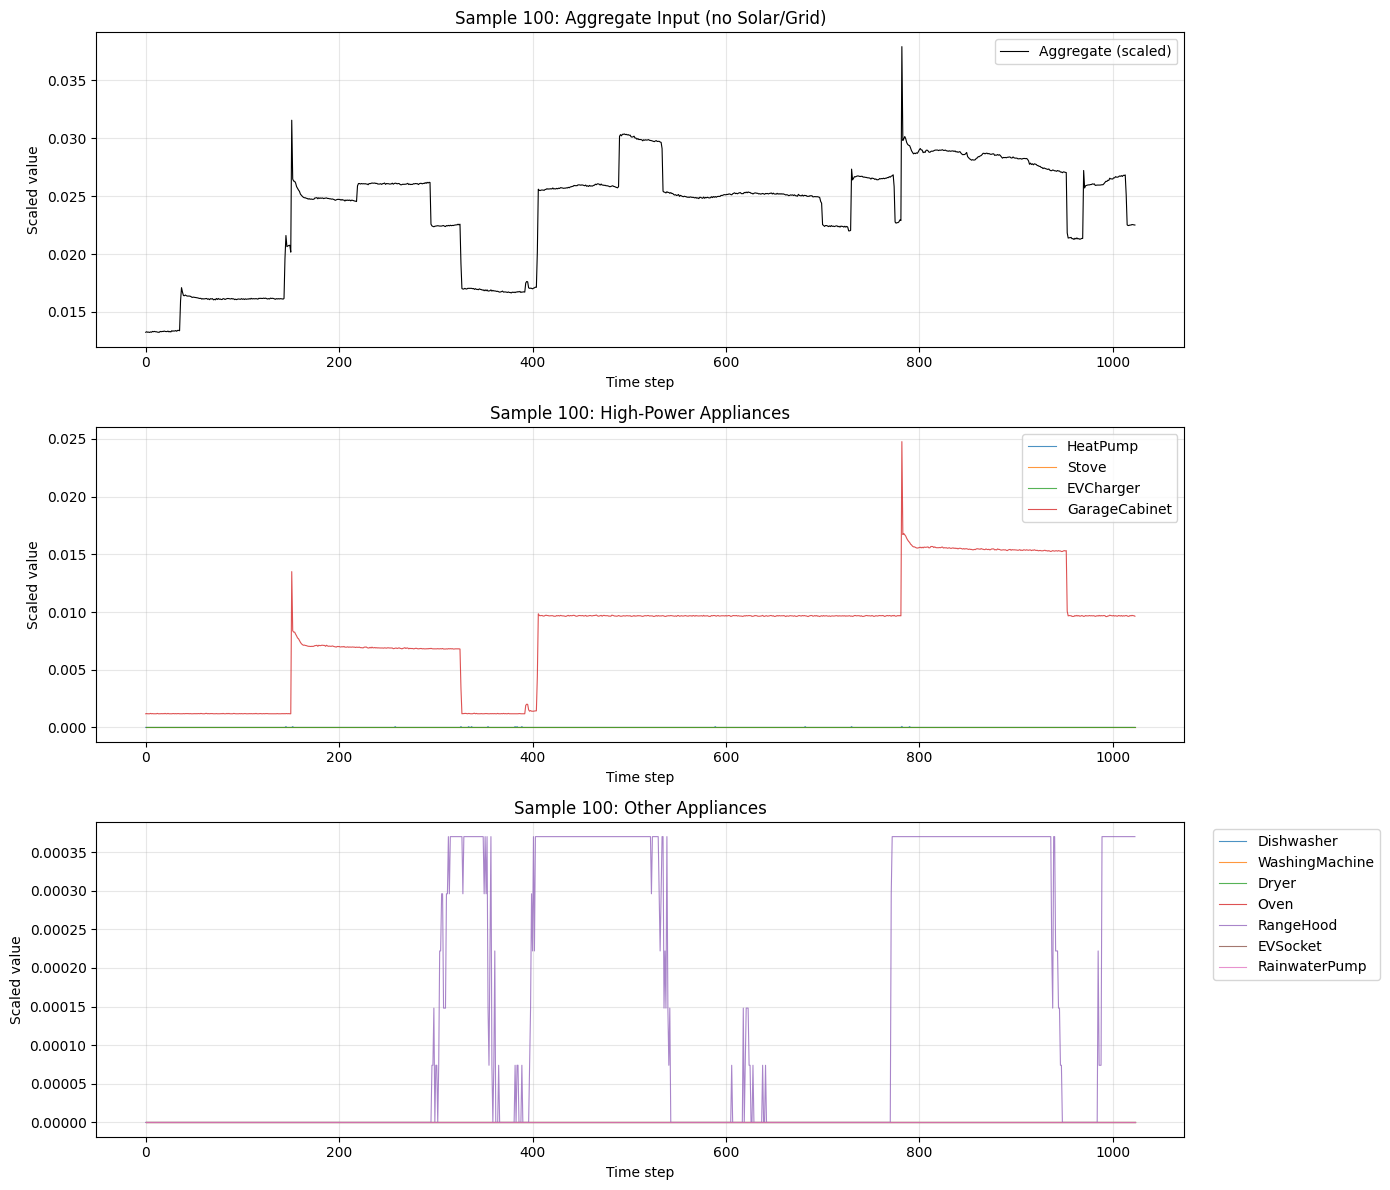

In [ ]:
import matplotlib.pyplot as plt

# Plot a sample sequence
sample_idx = 100

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Input (Aggregate + Temporal)
ax1 = axes[0]
ax1.plot(X_train[sample_idx, :, 0], label='Aggregate (scaled)', linewidth=0.8, color='black')
ax1.set_xlabel('Time step')
ax1.set_ylabel('Scaled value')
ax1.set_title(f'Sample {sample_idx}: Aggregate Input (scaled by P_MAX={P_MAX:.2f} kW)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Targets - High power appliances (using corrected variable)
ax2 = axes[1]
high_power = ['HeatPump', 'EVCharger', 'GarageCabinet', 'Stove']
for i, name in enumerate(target_appliance_names):
    if name in high_power:
        ax2.plot(y_train[sample_idx, :, i], label=name, alpha=0.8, linewidth=0.8)
ax2.set_xlabel('Time step')
ax2.set_ylabel('Scaled value')
ax2.set_title(f'Sample {sample_idx}: High-Power Appliances')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Targets - Low power appliances
ax3 = axes[2]
for i, name in enumerate(target_appliance_names):
    if name not in high_power:
        ax3.plot(y_train[sample_idx, :, i], label=name, alpha=0.8, linewidth=0.8)
ax3.set_xlabel('Time step')
ax3.set_ylabel('Scaled value')
ax3.set_title(f'Sample {sample_idx}: Other Appliances')
ax3.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Export Numpy Arrays

In [ ]:
print('='*70)
print('💾 EXPORTING NUMPY ARRAYS')
print('='*70)

# Save arrays
np.save(OUTPUT_DIR / 'X_train.npy', X_train)
np.save(OUTPUT_DIR / 'y_train.npy', y_train)
np.save(OUTPUT_DIR / 'X_val.npy', X_val)
np.save(OUTPUT_DIR / 'y_val.npy', y_val)
np.save(OUTPUT_DIR / 'X_test.npy', X_test)
np.save(OUTPUT_DIR / 'y_test.npy', y_test)

print(f'\n✅ Arrays saved to {OUTPUT_DIR}:')
for f in OUTPUT_DIR.glob('*.npy'):
    size_mb = f.stat().st_size / 1024 / 1024
    print(f'   {f.name}: {size_mb:.1f} MB')

💾 EXPORTING NUMPY ARRAYS

✅ Arrays saved to C:\Users\gamek\School\TeamProject\MTS3-MCTE-Team-Project-Energy-G1\data\processed\1sec_new\model_ready:
   X_test.npy: 129.1 MB
   X_train.npy: 539.9 MB
   X_val.npy: 129.1 MB
   y_test.npy: 202.9 MB
   y_train.npy: 848.4 MB
   y_val.npy: 202.9 MB


In [ ]:
# Save metadata (UPDATED with NILM-correct scaling info)
metadata = {
    # Resolution
    'resolution_sec': RESOLUTION_SEC,
    'original_resolution_sec': 1,
    'resampled': RESOLUTION_SEC > 1,
    
    # Window configuration
    'window_size': WINDOW_SIZE,
    'window_context_minutes': WINDOW_SIZE * RESOLUTION_SEC / 60,
    'window_context_hours': WINDOW_SIZE * RESOLUTION_SEC / 3600,
    'stride': STRIDE,
    'stride_minutes': STRIDE * RESOLUTION_SEC / 60,
    
    # Features (using corrected variable names)
    'input_features': input_feature_names,  # ['Aggregate', 'hour_sin', ...]
    'target_appliances': target_appliance_names,  # ['HeatPump', 'Dishwasher', ...]
    'all_feature_columns': all_feature_columns,  # Full order in scaled arrays
    'power_columns': POWER_COLUMNS,
    'temporal_columns': temporal_cols_exist,
    
    # NILM-correct scaling info
    'scaling': {
        'method': 'power / P_MAX (NILM-correct)',
        'P_MAX': float(P_MAX),
        'P_MAX_unit': 'kW',  # Data is in kW, not W!
        'P_MAX_watts': float(P_MAX * 1000),
        'notes': [
            'All power columns scaled by same P_MAX (energy conservation)',
            'Temporal sin/cos features NOT scaled',
            'For inference: power_kW = pred_scaled * P_MAX'
        ]
    },
    
    # Data split
    'split': {
        'method': 'block-interleaved (seasonal)',
        'block_days': BLOCK_DAYS,
        'pattern': PATTERN,
        'ratios': {
            'train': len(X_train) / (len(X_train) + len(X_val) + len(X_test)),
            'val': len(X_val) / (len(X_train) + len(X_val) + len(X_test)),
            'test': len(X_test) / (len(X_train) + len(X_val) + len(X_test))
        }
    },
    
    # Shapes
    'shapes': {
        'X_train': list(X_train.shape),
        'y_train': list(y_train.shape),
        'X_val': list(X_val.shape),
        'y_val': list(y_val.shape),
        'X_test': list(X_test.shape),
        'y_test': list(y_test.shape)
    },
    
    # Data source
    'data_source': f'1sec_new resampled to {RESOLUTION_SEC}sec',
    'power_unit': 'kW',
    'usable_periods': [
        {'period': 'B', 'start': '2024-07-01', 'end': '2024-09-30'},
        {'period': 'C', 'start': '2024-10-09', 'end': '2025-09-30'}
    ],
    
    # Notes
    'preprocessing_notes': [
        f'Original data: 1-second resolution in kW',
        f'Resampled to {RESOLUTION_SEC}-second via mean aggregation',
        f'Window {WINDOW_SIZE} samples = {WINDOW_SIZE * RESOLUTION_SEC / 3600:.1f} hours context',
        'NILM-correct scaling: all power / P_MAX (same scale)',
        'Temporal features (sin/cos) NOT scaled',
        'Solar, Grid, Battery NOT included',
        'Block-interleaved split (seasonal coverage)'
    ]
}

with open(OUTPUT_DIR / 'metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

# Also save as JSON for easy reading
import json
with open(OUTPUT_DIR / 'metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("="*70)
print("📋 METADATA SAVED")
print("="*70)
print(f'\nConfiguration Summary:')
print(f'  Resolution: {RESOLUTION_SEC}s (resampled from 1s)')
print(f'  Window: {WINDOW_SIZE} samples = {metadata["window_context_hours"]:.1f} hours')
print(f'  Stride: {STRIDE} samples = {metadata["stride_minutes"]:.0f} minutes')
print(f'  P_MAX: {P_MAX:.2f} kW = {P_MAX*1000:.0f} W')
print(f'\nFeatures:')
print(f'  Input: {len(input_feature_names)} (Aggregate + {len(temporal_cols_exist)} temporal)')
print(f'  Target: {len(target_appliance_names)} appliances')
print(f'\nSequences:')
print(f'  Training: {X_train.shape[0]:,}')
print(f'  Validation: {X_val.shape[0]:,}')
print(f'  Test: {X_test.shape[0]:,}')


✅ Metadata saved

Configuration Summary:
  Resolution: 5s (resampled from 1s)
  Window: 1024 samples = 1.4 hours
  Stride: 256 samples = 21 minutes
  Input features: 7
  Target appliances: 11

Sequences:
  Training: 19,745
  Validation: 4,722
  Test: 4,722


---
## ✅ Pretraining Complete (5-Second Resolution)

### Configuration Summary
| Parameter | Value | Description |
|-----------|-------|-------------|
| **Resolution** | 5 sec | Resampled from native 1sec |
| **Window size** | 1024 | = **1.4 HOURS** of context |
| **Stride** | 256 | = 21 minutes between samples |
| **P_MAX** | ~13.5 kW | Single scaling factor for all power |

### ⚡ NILM-Correct Scaling
| Category | Scaling | Notes |
|----------|---------|-------|
| **Aggregate** | `/ P_MAX` | P_MAX from TRAIN only |
| **All Appliances** | `/ P_MAX` | SAME P_MAX (energy conservation) |
| **Temporal (sin/cos)** | **None** | Already in [-1, 1] |

### Why This Scaling?
- ✅ **Energy Conservation**: Aggregate + Appliances on same scale
- ✅ **No Data Leakage**: P_MAX only from training set
- ✅ **Physical Meaning**: Values directly convertible to kW
- ❌ **NOT StandardScaler**: Would create artificial negatives
- ❌ **NOT per-appliance scaling**: Would break energy balance

### Output Files
| File | Description |
|------|-------------|
| X_train/val/test.npy | Input sequences (Aggregate + temporal) |
| y_train/val/test.npy | Target sequences (11 appliances) |
| scaling_params.pkl | P_MAX and feature info |
| P_MAX.pkl | Just the scaling factor |
| metadata.json/pkl | Full configuration |

### Input Features (7)
- Aggregate (scaled by P_MAX)
- hour_sin, hour_cos (raw)
- dow_sin, dow_cos (raw)
- month_sin, month_cos (raw)

### Target Appliances (11)
HeatPump, Dishwasher, WashingMachine, Dryer, Oven, Stove, RangeHood, EVCharger, EVSocket, GarageCabinet, RainwaterPump

### Data Split
- **Block interleaved (seasonal):** [Train, Train, Train, Train, Val, Test] weekly pattern
- **Train**: 67.6% | **Val**: 16.2% | **Test**: 16.2%

### Inference De-scaling
```python
# Load P_MAX
with open('P_MAX.pkl', 'rb') as f:
    P_MAX = pickle.load(f)

# De-scale predictions
power_kW = prediction * P_MAX
power_W = prediction * P_MAX * 1000
```

### Next Steps
1. Update Transformer config: `seq_len=1024`, `n_features=7`, `n_appliances=11`
2. Train model on 5-second data
3. Compare with 15min results
---